In [1]:
# Detect environment
import sys

try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
except:
    IN_COLAB = False
    print("🖥️ Running locally")

print(f"Python: {sys.version.split()[0]}")

✅ Running on Google Colab
Python: 3.12.12


In [2]:
# Install PyTorch Geometric
print("📦 Installing PyTorch Geometric...")
!pip install torch-geometric -q
print("✅ Installation complete!")

📦 Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:0000:01
✅ Installation complete!
✅ Installation complete!


In [3]:
# Import all required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [16]:
# Download CSV files from Google Drive (for Colab only)
if IN_COLAB:
    print("📥 Downloading CSV files from Google Drive...")
    
    # Install gdown for downloading from Google Drive
    !pip install gdown -q
    
    import gdown
    
    # Download nodes.csv
    nodes_url = 'https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA'
    gdown.download(nodes_url, 'nodes.csv', quiet=False)
    print("✅ Downloaded nodes.csv")
    
    # Download edges.csv
    edges_url = 'https://drive.google.com/uc?id=1TrALouCEaJLj22BbSzi3zmWzIUQJUTn8'
    gdown.download(edges_url, 'edges.csv', quiet=False)
    print("✅ Downloaded edges.csv")
    
    print("\n✅ Both CSV files downloaded successfully to current directory")
else:
    print("⏭️ Skipping download (running locally - using local CSV files)")

📥 Downloading CSV files from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA
To: /content/nodes.csv
100%|██████████| 1.06k/1.06k [00:00<00:00, 4.13MB/s]



✅ Downloaded nodes.csv


Downloading...
From: https://drive.google.com/uc?id=1TrALouCEaJLj22BbSzi3zmWzIUQJUTn8
To: /content/edges.csv
100%|██████████| 1.94k/1.94k [00:00<00:00, 7.48MB/s]

✅ Downloaded edges.csv

✅ Both CSV files downloaded successfully to current directory


In [23]:
# ============================================================
# STEP 1: Load Node Data from CSV
# ============================================================

import os

# Determine the correct path based on environment
if IN_COLAB:
    # For Colab: Downloaded files should be in current directory
    possible_paths = [
        'nodes.csv',  # Current directory (downloaded)
        '/content/nodes.csv',  # Standard Colab path
        '../data/nodes.csv',  # Relative path
    ]
    
    nodes_df = None
    for path in possible_paths:
        if os.path.exists(path):
            nodes_df = pd.read_csv(path)
            print(f"✅ Loaded nodes.csv from {path}")
            break
    
    if nodes_df is None:
        # Fallback to embedded sample data
        print("⚠️ nodes.csv not found in any location - using embedded sample data")
        print("💡 For full dataset, ensure CSV files are in ../data/ or /content/ directory")
        
        # Create sample nodes data directly
        nodes_df = pd.DataFrame({
        'name': ['Colombo', 'Kandy', 'Galle', 'Anuradhapura', 'Ella', 
                 'Negombo', 'Matara', 'Dambulla', 'Nuwara Eliya', 'Trincomalee'],
        'region': ['urban', 'hill', 'coastal', 'cultural', 'hill', 
                   'coastal', 'coastal', 'cultural', 'hill', 'coastal'],
        'latitude': [6.9271, 7.2906, 6.0535, 8.3114, 6.8667, 
                     7.2094, 5.9549, 7.8742, 6.9497, 8.5874],
        'longitude': [79.8612, 80.6337, 80.2210, 80.4037, 81.0467, 
                      79.8358, 80.5550, 80.6511, 80.7891, 81.2152],
        'popularity': [1.0, 0.85, 0.75, 0.70, 0.80, 
                       0.65, 0.60, 0.70, 0.75, 0.65],
        'disruption_flag': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'description': ['Capital city', 'Hill country', 'Coastal city', 'Ancient city', 'Scenic town',
                        'Beach town', 'Southern city', 'Cultural triangle', 'Hill station', 'Port city']
    })
    print("✅ Using sample data with 10 nodes")
else:
    # For local: Use relative path to load full dataset
    nodes_path = '../data/nodes.csv'
    nodes_df = pd.read_csv(nodes_path)
    print("✅ Loaded full dataset from CSV")

print("\n📊 Loaded Nodes Dataset")
print(f"Total nodes: {len(nodes_df)}")
print(f"\nColumns: {list(nodes_df.columns)}")
print(f"\nFirst 5 nodes:")
print(nodes_df.head())
print(f"\nRegions distribution:")
print(nodes_df['region'].value_counts())

✅ Loaded nodes.csv from nodes.csv
✅ Using sample data with 10 nodes

📊 Loaded Nodes Dataset
Total nodes: 15

Columns: ['name', 'region', 'latitude', 'longitude', 'popularity', 'disruption_flag', 'description']

First 5 nodes:
           name    region  latitude  longitude  popularity  disruption_flag  \
0       Colombo     urban    6.9271    79.8612        1.00                0   
1         Kandy      hill    7.2906    80.6337        0.90                0   
2         Galle   coastal    6.0535    80.2210        0.85                0   
3  Anuradhapura  cultural    8.3114    80.4037        0.75                0   
4          Ella      hill    6.8667    81.0467        0.88                0   

                                 description  
0            Main commercial hub and capital  
1           Cultural capital in hill country  
2            Southern coastal city with fort  
3         Ancient city with historical sites  
4  Scenic hill station popular with tourists  

Regions distribu

In [24]:
# ============================================================
# STEP 2: Load Edge Data from CSV
# ============================================================

# Determine the correct path based on environment
if IN_COLAB:
    # For Colab: Downloaded files should be in current directory
    possible_paths = [
        'edges.csv',  # Current directory (downloaded)
        '/content/edges.csv',  # Standard Colab path
        '../data/edges.csv',  # Relative path
    ]
    
    edges_df = None
    for path in possible_paths:
        if os.path.exists(path):
            edges_df = pd.read_csv(path)
            print(f"✅ Loaded edges.csv from {path}")
            break
    
    if edges_df is None:
        # Fallback to embedded sample data
        print("⚠️ edges.csv not found in any location - using embedded sample edge data")
        print("💡 For full dataset, ensure CSV files are in ../data/ or /content/ directory")
        
        # Create sample edges data with realistic Sri Lankan routes
        edges_df = pd.DataFrame({
        'origin': ['Colombo', 'Colombo', 'Colombo', 'Colombo', 'Colombo', 'Colombo',
                   'Kandy', 'Kandy', 'Kandy', 'Galle', 'Dambulla', 'Ella',
                   'Negombo', 'Anuradhapura', 'Matara'],
        'destination': ['Kandy', 'Kandy', 'Galle', 'Anuradhapura', 'Negombo', 'Matara',
                        'Ella', 'Dambulla', 'Nuwara Eliya', 'Matara', 'Anuradhapura', 'Nuwara Eliya',
                        'Colombo', 'Trincomalee', 'Galle'],
        'mode': ['train', 'bus', 'train', 'bus', 'bus', 'bus',
                 'train', 'bus', 'bus', 'bus', 'bus', 'bus',
                 'bus', 'bus', 'bus'],
        'distance_km': [120, 120, 120, 205, 40, 160,
                        137, 72, 77, 40, 70, 60,
                        40, 150, 40],
        'travel_time_hours': [3.0, 3.5, 2.5, 5.0, 1.0, 4.0,
                              7.0, 2.5, 3.0, 1.5, 2.0, 2.5,
                              1.0, 4.0, 1.5],
        'fare_lkr': [250, 180, 200, 250, 100, 220,
                     280, 120, 150, 80, 100, 150,
                     100, 250, 80],
        'frequency_per_day': [15, 30, 20, 15, 40, 18,
                              8, 20, 15, 25, 12, 10,
                              50, 10, 30],
        'difficulty': [2, 3, 1, 3, 1, 2,
                       4, 3, 3, 1, 2, 4,
                       1, 3, 1],
        'availability': [0.92, 0.88, 0.95, 0.80, 0.95, 0.85,
                         0.70, 0.87, 0.82, 0.92, 0.85, 0.82,
                         0.98, 0.75, 0.93],
        'peak_hours': ['6-9,16-19', '5-10,15-20', '6-8,17-19', '5-8,14-18', '6-10,16-21', '5-9,15-19',
                       '6-7,14-15', '6-9,15-18', '6-9,15-18', '6-10,16-20', '6-8,15-17', '7-9,15-17',
                       '5-22', '6-9,14-17', '5-10,15-20'],
        'service_quality': ['excellent', 'good', 'excellent', 'fair', 'excellent', 'good',
                            'excellent', 'good', 'good', 'good', 'good', 'good',
                            'excellent', 'fair', 'good']
    })
    print("✅ Using sample data with 15 edges")
else:
    # For local: Use relative path to load full dataset
    edges_path = '../data/edges.csv'
    edges_df = pd.read_csv(edges_path)
    print("✅ Loaded full dataset from CSV")

print("\n📊 Loaded Edges Dataset")
print(f"Total edges (routes): {len(edges_df)}")
print(f"\nColumns: {list(edges_df.columns)}")
print(f"\nFirst 5 routes:")
print(edges_df.head())
print(f"\nTransport modes:")
print(edges_df['mode'].value_counts())
print(f"\nAvailability statistics:")
print(f"  Mean: {edges_df['availability'].mean():.3f}")
print(f"  Min: {edges_df['availability'].min():.3f}")
print(f"  Max: {edges_df['availability'].max():.3f}")

✅ Loaded edges.csv from edges.csv
✅ Using sample data with 15 edges

📊 Loaded Edges Dataset
Total edges (routes): 30

Columns: ['origin', 'destination', 'mode', 'distance_km', 'travel_time_hours', 'fare_lkr', 'frequency_per_day', 'difficulty', 'availability', 'peak_hours', 'service_quality']

First 5 routes:
    origin   destination   mode  distance_km  travel_time_hours  fare_lkr  \
0  Colombo         Kandy  train          120                3.0       250   
1  Colombo         Kandy    bus          120                3.5       180   
2  Colombo         Galle  train          120                2.5       200   
3  Colombo         Galle    bus          120                3.0       150   
4  Colombo  Anuradhapura  train          205                4.5       300   

   frequency_per_day  difficulty  availability  peak_hours service_quality  
0                 15           2          0.92   6-9,16-19       excellent  
1                 30           3          0.88  5-10,15-20            goo

In [25]:
# ============================================================
# STEP 3: Convert CSV Data to Graph-Ready Format
# ============================================================

# Convert nodes DataFrame to list of dictionaries
nodes = []
for _, row in nodes_df.iterrows():
    node_dict = {
        'name': row['name'],
        'region': row['region'],
        'popularity': row['popularity'],
        'disruption_flag': row['disruption_flag'],
        'latitude': row['latitude'],
        'longitude': row['longitude']
    }
    nodes.append(node_dict)

# Convert edges DataFrame to list of tuples
edges = []
for _, row in edges_df.iterrows():
    edge_tuple = (
        row['origin'],
        row['destination'],
        {
            'mode': row['mode'],
            'distance': row['distance_km'],
            'travel_time': row['travel_time_hours'],
            'fare': row['fare_lkr'],
            'frequency': row['frequency_per_day'],
            'difficulty': row['difficulty'],
            'availability': row['availability'],
            'peak_hours': row['peak_hours'],
            'service_quality': row['service_quality']
        }
    )
    edges.append(edge_tuple)

print(f"✅ Converted data to graph format")
print(f"   Nodes: {len(nodes)}")
print(f"   Edges: {len(edges)}")
print(f"\nSample node: {nodes[0]}")
print(f"\nSample edge: {edges[0]}")

✅ Converted data to graph format
   Nodes: 15
   Edges: 30

Sample node: {'name': 'Colombo', 'region': 'urban', 'popularity': 1.0, 'disruption_flag': 0, 'latitude': 6.9271, 'longitude': 79.8612}

Sample edge: ('Colombo', 'Kandy', {'mode': 'train', 'distance': 120, 'travel_time': 3.0, 'fare': 250, 'frequency': 15, 'difficulty': 2, 'availability': 0.92, 'peak_hours': '6-9,16-19', 'service_quality': 'excellent'})


In [26]:
# Example static schedule info for Colombo
colombo_schedule = {
    "bus_schedules": {
        "Kandy": {
            "normal":   [6.0, 10.0, 14.0, 18.0],
            "luxury":   [7.5, 13.0, 17.5],
            "semi-luxury": [8.0, 16.0],
            "highway":  [9.0, 15.0, 21.0]
        },
        "Galle": {
            "normal":   [5.5, 9.0, 18.0],
            "luxury":   [8.15, 14.0]
        },
    },
    "train_schedules": {
        "Kandy": {
            "express":  [7.25, 12.5, 18.0],
            "intercity": [6.0, 10.5, 16.0]
        }
    },
    "disruption_flag": 0
}

# Feature extraction helpers
def get_next_and_num_deps(times, now=12.0): 
    future = [t for t in times if t > now]
    if len(future) == 0:
        return 24.0, 0 
    next_dep = min(future)
    return next_dep - now, len(future)  

now = 12.0
next_norm, n_left_norm = get_next_and_num_deps(colombo_schedule["bus_schedules"]["Kandy"]["normal"], now)
print("Next normal bus to Kandy in hours:", next_norm, "; Departures left today:", n_left_norm)


Next normal bus to Kandy in hours: 2.0 ; Departures left today: 2


In [28]:


# ============================================================
# STEP 4: Build NetworkX Graph from CSV Data
# ============================================================

# Build the multigraph using CSV data
G = nx.MultiGraph()

# Add nodes from CSV data
for node in nodes:
    G.add_node(node["name"], **node)

# Add edges from CSV data
for u, v, attr in edges:
    G.add_edge(u, v, **attr)

print(f"✅ Built NetworkX MultiGraph")
print(f"   Total nodes: {G.number_of_nodes()}")
print(f"   Total edges: {G.number_of_edges()}")

# ============================================================
# STEP 5: Build PyTorch Geometric Data
# ============================================================

# Build node feature matrix
# Dynamically build region map from actual data
unique_regions = sorted(set(node["region"] for node in nodes))
region_map = {region: idx for idx, region in enumerate(unique_regions)}
print(f"Found regions: {unique_regions}")
print(f"Region map: {region_map}")

node2idx = {n["name"]: idx for idx, n in enumerate(nodes)}
node_feats = []
for node in nodes:
    region_vec = [0] * len(unique_regions)  # One-hot encoding for all regions
    region_vec[region_map[node["region"]]] = 1
    popularity = node["popularity"]
    disruption = node.get("disruption_flag", 0)
    latitude = node.get("latitude", 0)
    longitude = node.get("longitude", 0)
    # Features: [region one-hot, popularity, disruption, lat, lon]
    node_feats.append(region_vec + [popularity, disruption, latitude, longitude])

X = torch.tensor(node_feats, dtype=torch.float)
print(f"✅ Node feature matrix shape: {X.shape}")

# Build edge index and features
src, dst, edge_attrs = [], [], []
for u, v, data in G.edges(data=True):
    src.append(node2idx[u])
    dst.append(node2idx[v])
    mode = {"bus": 0, "train": 1, "tuk-tuk": 2}.get(data["mode"], 0)
    distance = data.get("distance", 0)
    travel_time = data.get("travel_time", 0)
    frequency = data.get("frequency", 0)
    difficulty = data.get("difficulty", 0)
    # Edge features: [distance, mode, travel_time, frequency, difficulty]
    edge_attrs.append([distance, mode, travel_time, frequency, difficulty])

edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

# Target: edge availability (from CSV data)
edge_labels = []
for u, v, data in G.edges(data=True):
    availability = data.get("availability", 0.5)
    edge_labels.append(availability)
edge_labels = torch.tensor(edge_labels, dtype=torch.float)

# Create PyTorch Geometric Data object
data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

print(f"✅ PyTorch Geometric Data created")
print(f"   Node features: {data.x.shape}")
print(f"   Edge index: {data.edge_index.shape}")
print(f"   Edge features: {data.edge_attr.shape}")
print(f"   Edge labels (availability): {data.y.shape}")


✅ Built NetworkX MultiGraph
   Total nodes: 15
   Total edges: 30
Found regions: ['coastal', 'cultural', 'hill', 'northern', 'urban']
Region map: {'coastal': 0, 'cultural': 1, 'hill': 2, 'northern': 3, 'urban': 4}
✅ Node feature matrix shape: torch.Size([15, 9])
✅ PyTorch Geometric Data created
   Node features: torch.Size([15, 9])
   Edge index: torch.Size([2, 30])
   Edge features: torch.Size([30, 5])
   Edge labels (availability): torch.Size([30])


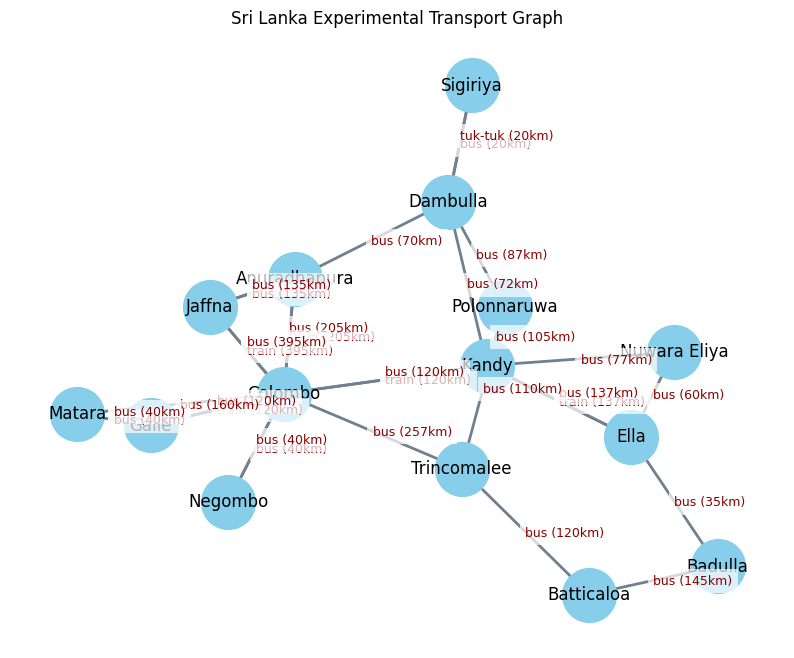

In [29]:


# Build simple labels for edges: show mode and distance
edge_labels = {}
for u, v, key, data in G.edges(data=True, keys=True):
    label = f"{data['mode']} ({data['distance']}km)"
    edge_labels[(u, v, key)] = label

# Draw MultiGraph with labeled edges and nodes
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42) 
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')

# Draw edges (all modes)
nx.draw_networkx_edges(G, pos, width=2, edge_color='slategray')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12)

# For MultiGraph, use edge_key to handle parallel edges
for (u, v, key), label in edge_labels.items():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    x, y = (x1 + x2) / 2, (y1 + y2) / 2
    plt.text(x, y + (key-0.5)*0.03, label, fontsize=9, color='darkred', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Sri Lanka Experimental Transport Graph')
plt.axis('off')
plt.show()


In [30]:
class SimpleEdgeGNN(nn.Module):
    def __init__(self, node_in, hidden, edge_in):
        super().__init__()
        self.c1 = GCNConv(node_in, hidden)
        self.c2 = GCNConv(hidden, hidden)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden*2 + edge_in, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, data):
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        src, dst = data.edge_index
        edge_inputs = torch.cat([x[src], x[dst], data.edge_attr], dim=1)
        out = self.edge_mlp(edge_inputs).squeeze()
        return out
